<a href="https://colab.research.google.com/github/VinayKanakeri/STN_NNFL/blob/master/STN_NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the reository to your drive, and pull the files. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Projects/NNFL/STN_NNFL
!git clone 'https://github.com/VinayKanakeri/STN_NNFL.git'
! git pull


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Projects/NNFL/STN_NNFL
fatal: destination path 'STN_NNFL' already exists and is not an empty directory.
Already up to date.


Print all the cloned files.

In [2]:
ls

augmentation.py      mnist_keras_load.py  README.md                 utils.py
bilinear_sampler.py  model.py             samplerNinterpolation.py
main.py              __pycache__/         STN_NNFL/


Import these libraries.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math
!pip install tensorlayer

     |████████████████████████████████| 368kB 9.3MB/s 
     |████████████████████████████████| 3.3MB 34.4MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


Run these python files.

In [3]:
%matplotlib inline 
%run mnist_keras_load.py
%run augmentation.py
%run utils.py
%run bilinear_sampler.py
%run model.py
%run samplerNinterpolation.py

Using TensorFlow backend.


Import the required functions. 

In [0]:
from augmentation import aug_data
from mnist_keras_load import starter
from model import STN_Model
from samplerNinterpolation import sample_interpolate
from utils import get_initial_weights, random_mini_batches, append_shuffle

Load the dataset and augment it. Random rotation, scale, shift, and shear is applied for augmenting.

In [7]:
train_x, train_label, val_x, val_label, test_x, test_label = starter()
train_data,val_data,test_data = aug_data(train_x,val_x,test_x)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 10)
(10000, 10)


Use the following function to visualize randomly picked images with their labels.

In [0]:
def plot_imagesNlabels(data, labels):
	rand_mine = np.random.randint(0,data.shape[0],12)
	sampled_x = data[rand_mine]
	sampled_y = labels[rand_mine].reshape(12,10)
	num_rows = 2
	num_cols = 6
	f, ax = plt.subplots(num_rows, num_cols, figsize = (12,5), gridspec_kw = {'wspace':0.03 , 'hspace':0.01}, squeeze = True)
	for i in range (num_rows):
		for j in range (num_cols):
			image_index = i*6 + j
			ax[i,j].axis("off")
			ax[i,j].imshow(np.squeeze(sampled_x[image_index]), cmap='gray')
			ax[i,j].set_title('No. %d' % np.where(sampled_y[image_index] == 1))
	plt.show()

Now let us check the original dataset and augmented data.

Original dataset:



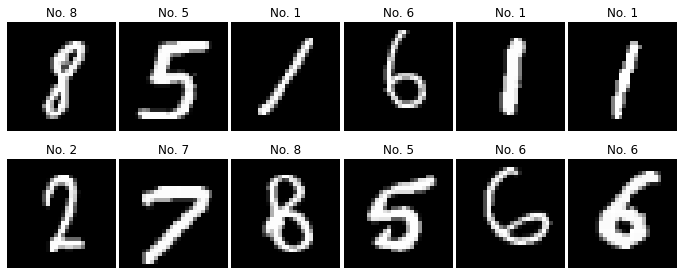

Augmented data:



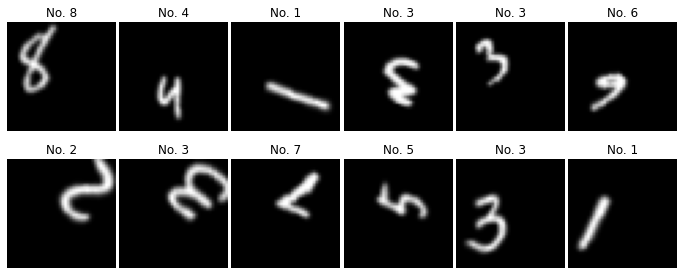

In [14]:
print("Original dataset:\n")
plot_imagesNlabels(train_x,train_label)
print("Augmented data:\n")
plot_imagesNlabels(train_data,train_label)

Let us load the model and print the summary of our model.

In [5]:
model = STN_Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
STN_Input (InputLayer)          [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 38, 38, 16)   160         STN_Input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 19, 19, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    2056        max_pooling2d[0][0]              
______________________________________________________________________________________________

Run the following code to plot the model:

In [0]:
keras.utils.plot_model(model, 'STN.png', show_shapes=True)

The following funtion trains and prints the results:

In [0]:
def train_STN(learning_rate=1e-3, batch_size = 64, num_epochs = 10, print_steps = 200):

  # Instantiate an optimizer.
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  # Instantiate a loss function.
  #loss_fn = keras.losses.categorical_crossentropy(from_logits=True)

  #define metrics
  train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

  train_data_1 = train_data[:,:,:,np.newaxis]
  val_data_1 = val_data[:,:,:,np.newaxis]
  batch_size = batch_size
  train_dataset = tf.data.Dataset.from_tensor_slices((train_data_1, train_label))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  #prepare val dataset
  val_dataset = tf.data.Dataset.from_tensor_slices((val_data_1, val_label))
  val_dataset = val_dataset.batch(64)

  epochs = num_epochs
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      #gradient tape records forward pass allowing the optimizer to perform back propagation
      with tf.GradientTape() as tape:
        #logits contain predicted value (output)
        logits = model(x_batch_train, training=True)
        print(y_batch_train.shape)
        print(logits.shape)
        loss_value = keras.losses.categorical_crossentropy(y_batch_train, logits, from_logits=True)
      #retrieve the gradients
      grads = tape.gradient(loss_value, model.trainable_weights)
      #update the weights and biases
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      if step % print_steps == 0:
        print('Training loss (for one batch) at step %s: %f' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
      val_logits = model(x_batch_val)
      # Update val metrics
      val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))



Let us train our model

In [29]:
train_STN(0.001,64,2,100)

Start of epoch 0
(64, 10)
(64, 10)


TypeError: ignored

In [19]:
print(y_batch_train.shape)
print(train_label.shape)

NameError: ignored